# Lista 4
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)
___

## Importy

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from xgboost import XGBClassifier

___
## Zadanie 1
Zbudowano drzewo decyzyjne dla zbioru Iris bez ograniczenia głębokości. Wizualizacja pokazuje kolejne warunki podziału — głównie na podstawie **długości i szerokości płatków (petal length, petal width)**, które najlepiej rozróżniają gatunki. Każdy węzeł zawiera informację o liczbie próbek i przewidywanej klasie, co pozwala zrozumieć, jak model podejmuje decyzje.

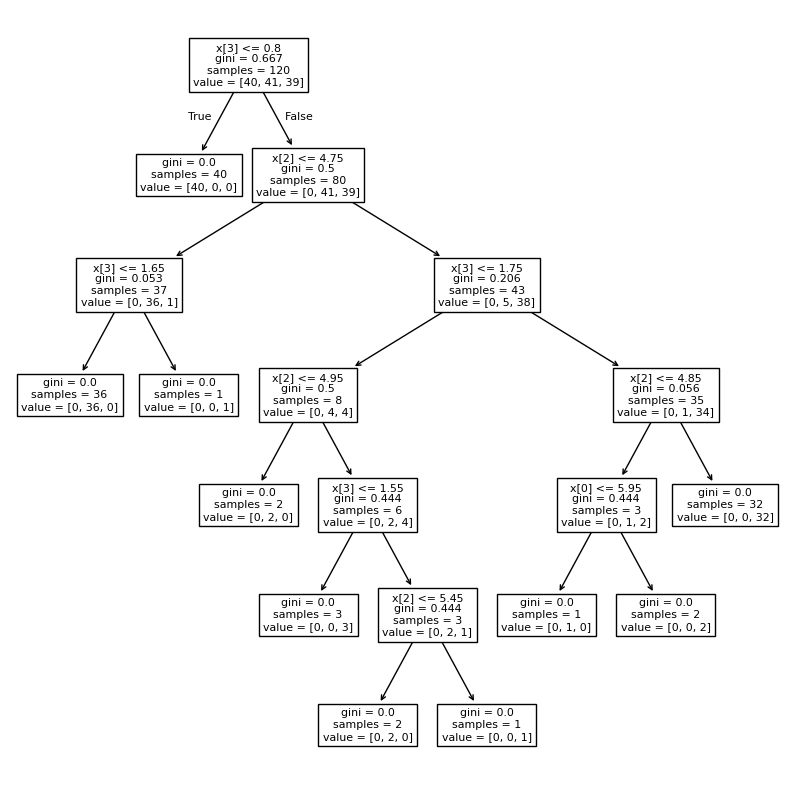

In [36]:
data_iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data_iris.data, data_iris.target, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

plt.figure(figsize=(10,10))
plot_tree(model)
plt.show()

___
## Zadanie 2
W zadaniu porównano dwa drzewa decyzyjne: jedno bez ograniczeń i drugie z maksymalną głębokością równą 3.

In [37]:
data_iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data_iris.data, data_iris.target, test_size=0.2, random_state=42)

first_model = DecisionTreeClassifier()
first_model.fit(X_train, y_train)

second_model = DecisionTreeClassifier(max_depth=3)
second_model.fit(X_train, y_train)

y_pred_train_first = first_model.predict(X_train)
y_pred_train_second = second_model.predict(X_train)

y_pred_test_first = first_model.predict(X_test)
y_pred_test_second = second_model.predict(X_test)

print(f'Dokładność pierwszego modelu na zbiorze treningowym: {accuracy_score(y_train, y_pred_train_first):.2f}')
print(f'Dokładność drugiego modelu na zbiorze treningowym: {accuracy_score(y_train, y_pred_train_second):.2f}')
print(f'Dokładność pierwszego modelu na zbiorze testowym: {accuracy_score(y_test, y_pred_test_first):.2f}')
print(f'Dokładność drugiego modelu na zbiorze testowym: {accuracy_score(y_test, y_pred_test_second):.2f}')

Dokładność pierwszego modelu na zbiorze treningowym: 1.00
Dokładność drugiego modelu na zbiorze treningowym: 0.96
Dokładność pierwszego modelu na zbiorze testowym: 1.00
Dokładność drugiego modelu na zbiorze testowym: 1.00


Wyniki pokazują, że w tym przypadku oba modele generalizują bardzo dobrze. Pierwsze drzewo, choć bez ograniczeń, osiągnęło 100% dokładności zarówno na zbiorze treningowym, jak i testowym, co oznacza, że dane Iris są na tyle proste i dobrze rozdzielone, że nawet złożony model nie ulega przeuczeniu.

Drzewo ograniczone do `max_depth=3` również osiągnęło wysoką dokładność (0.96 na treningu, 1.00 na teście), co potwierdza, że ograniczenie głębokości nie pogarszało zdolności generalizacji w tym przypadku. Zjawisko **overfittingu** nie wystąpiło, ponieważ problem jest stosunkowo prosty i separowalny liniowo lub niemal liniowo w cechach.

___
## Zadanie 3
Zbudowano model **lasu losowego (Random Forest)** na danych Iris i oceniono jego dokładność na zbiorze testowym. Lasy losowe składają się z wielu drzew decyzyjnych trenowanych na różnych podzbiorach danych i cech (bootstrap + losowy wybór cech), a ostateczna predykcja powstaje przez **głosowanie większościowe**.

In [38]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f'Dokładność lasu losowego na zbiorze testowym: {accuracy_score(y_test, y_pred):.2f}')

Dokładność lasu losowego na zbiorze testowym: 1.00


___
## Zadanie 4
Dla wytrenowanego lasu losowego obliczono **ważność poszczególnych cech**, która mierzy, w jakim stopniu dana zmienna przyczynia się do poprawy podziału w drzewach.

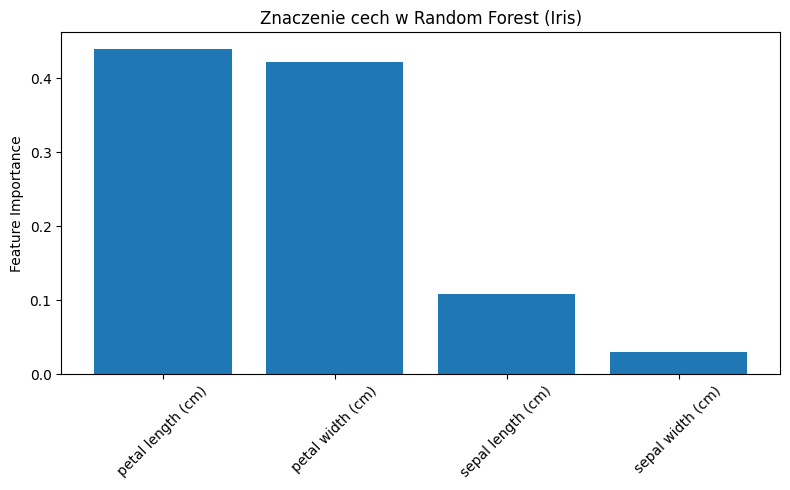

In [39]:
importances = model.feature_importances_
feature_names = data_iris.feature_names
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Feature Importance")
plt.title("Znaczenie cech w Random Forest (Iris)")
plt.tight_layout()
plt.show()


Wyniki pokazują, że długość i szerokość płatków (petal length i petal width) mają największy wpływ na klasyfikację gatunków Iris, co oznacza, że to właśnie te cechy najlepiej rozdzielają klasy. Pozostałe zmienne, jak długość i szerokość działki kielicha (sepal length/width), mają mniejszy wkład w decyzje modelu. Wizualizacja ułatwia szybką identyfikację najistotniejszych predyktorów.

___
## Zadanie 5
W zadaniu zastosowano AdaBoost, czyli algorytm wzmacniający klasyfikatory (boosting), który iteracyjnie buduje sekwencję prostych klasyfikatorów (np. drzew) i skupia się na obserwacjach, które poprzednie modele klasyfikowały błędnie.

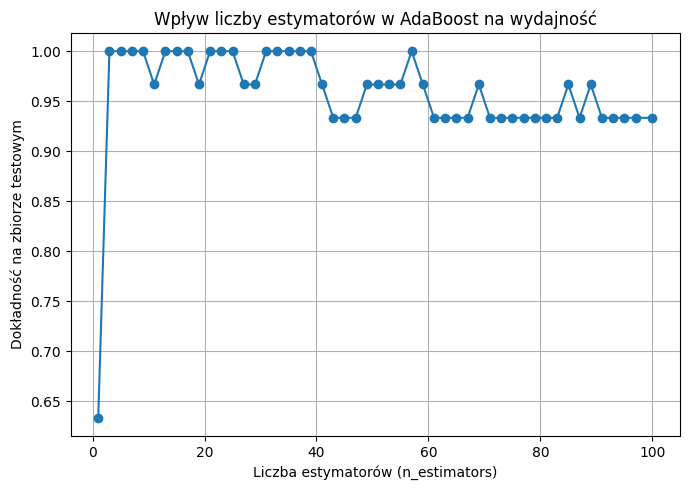

In [44]:
estimators = np.linspace(1, 100, 50, dtype=int)
accuracy_scores = []

for n in estimators:
    ada = AdaBoostClassifier(n_estimators=n, random_state=42)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

plt.figure(figsize=(7,5))
plt.plot(estimators, accuracy_scores, marker='o')
plt.xlabel("Liczba estymatorów (n_estimators)")
plt.ylabel("Dokładność na zbiorze testowym")
plt.title("Wpływ liczby estymatorów w AdaBoost na wydajność")
plt.grid(True)
plt.tight_layout()
plt.show()


Analiza różnych wartości n_estimators pokazuje, że większa liczba estymatorów zwykle poprawia dokładność, ponieważ model uczy się coraz lepiej poprawiać błędy wcześniejszych klasyfikatorów. Jednak po pewnym punkcie dalsze zwiększanie liczby estymatorów daje coraz mniejsze korzyści, a w skrajnych przypadkach może prowadzić do lekkiego przeuczenia.

___
## Zadanie 6
Wytrenowano model **Gradient Boosting** i porównano jego dokładność z lasem losowym. Gradient Boosting osiąga bardzo wysoką skuteczność, podobnie jak Random Forest, ale **sposób budowy modelu jest inny**:

* **Random Forest** tworzy wiele drzew równolegle na losowych podzbiorach danych i cech, a wyniki agreguje przez głosowanie — model bazuje na niezależnych drzewach.
* **Gradient Boosting** buduje drzewa **sekwencyjnie**, każde kolejne drzewo stara się poprawić błędy poprzednich poprzez minimalizację funkcji straty, co daje większą zdolność do redukcji błędów, ale kosztem większej wrażliwości na szum i potencjalnego przeuczenia.

W praktyce Gradient Boosting jest często skuteczniejszy przy trudniejszych problemach, ale wymaga ostrożnej regularyzacji i strojenia hiperparametrów.

In [58]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
acc_rf = accuracy_score(y_test, y_pred_test_second)

print(f"Dokładność Gradient Boosting: {acc_gb:.2f}")
print(f"Dokładność Random Forest: {acc_rf:.2f}")

Dokładność Gradient Boosting: 1.00
Dokładność Random Forest: 1.00


___
## Zadanie 7

W tym zadaniu wytrenowano model **XGBoost**, czyli wydajną implementację gradient boosting, na zbiorze Iris. Porównanie z innymi modelami pokazuje, że XGBoost osiąga podobną lub nieco wyższą dokładność przy krótszym czasie trenowania.

**XGBoost** jest popularny w konkursach Data Science, ponieważ:

* jest bardzo **szybki i skalowalny**, dzięki optymalizacjom niskopoziomowym i równoległemu przetwarzaniu,
* obsługuje różne funkcje straty i regularyzację, co zmniejsza ryzyko przeuczenia,
* łatwo radzi sobie z brakami danych i dużymi zbiorami cech,
* daje możliwość precyzyjnego strojenia hiperparametrów, co pozwala uzyskiwać modele o bardzo wysokiej skuteczności.

In [56]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier()
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc, "Training time (s)": end-start})

results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Training time (s)
0,Random Forest,1.000000,0.060020
1,Gradient Boosting,1.000000,0.128175
2,AdaBoost,0.933333,0.038613
3,XGBoost,1.000000,0.020133
